In [1]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer 
from typing import Tuple, List, Type, Dict, Any

In [2]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Task 1
3-layer Perceptron will have the following architecture:
- 128 nodes in the hidden layer
- tanh() activation function
- softmax() as an output activation function
- cross-entropy loss function

In [3]:
class Perceptron(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1, 
                 hidden_layer_features: List[int] = [256, 256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.Tanh,
                 num_classes: int = 10):
        
        
        super().__init__()
        
        self.input_resolution = input_resolution
        self.input_channels = input_channels
        self.hidden_layer_features = hidden_layer_features
        self.activation = activation()
        self.num_classes = num_classes
        
        # Layers:
        self.fc1 = torch.nn.Linear(self.input_resolution[0] * self.input_resolution[1], 128)
        self.fc2 = torch.nn.Linear(128, self.num_classes)
        
    def forward(self, X : Type[torch.Tensor]) -> Type[torch.Tensor]:
        
        X = self.fc1(X)
        X = self.activation(X)
        
        X = self.fc2(X)
        output = F.log_softmax(X, dim = 1) # softmax activation function is in the CrossEntropyLoss
        
        return output

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU


In [5]:
model = Perceptron()
model.to(device)
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Perceptron(
  (activation): Tanh()
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Total number of trainable parameters 101770


# Task 2
Data augmentation gives us additional data, that helps us to avoid _overfitting_.  
Also we can get some new examples,  
that will be slightly different from original ones,  
which will also improve generalization (e.g. shifting digits in MNIST dataset gives our network an ability to distinguish a lot more images,  
even if they are not from MNIST). 

# Task 3
1) Cropping, shifting, rotating, isolating color channels, flipping hor. axes, making it darker/lighter, adding effects (e.g. adding fog/rain in the photoshop), changing contrast.  
2) Changing volume, noise injection, changing speed, changing pitch, shifting time (e.g. cut first/last seconds)  
3) Noise injection, adding data from past different weather forecasts, adding data from other meteostations.

# Task 4
We'll use mean and std of the entire dataset to normalize data to avoid loosing correlation between pixels  
0.1307 and 0.3081 are mean and std values of MNIST dataset.

In [6]:
train_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
valid_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])

In [7]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms)

valid_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=valid_transforms)

In [8]:
data = list()
for i in range(len(train_dataset)):
    data.append(train_dataset[i][0].numpy())
data = np.array(data)
print('mean:', data.mean())
print('std:', data.std())
del data

mean: -0.00012829367
std: 1.0000249


In [9]:
print('Training set size: {}'.format(len(train_dataset)))
print('Cross-validation set size: {}'.format(len(valid_dataset)))

Training set size: 60000
Cross-validation set size: 10000


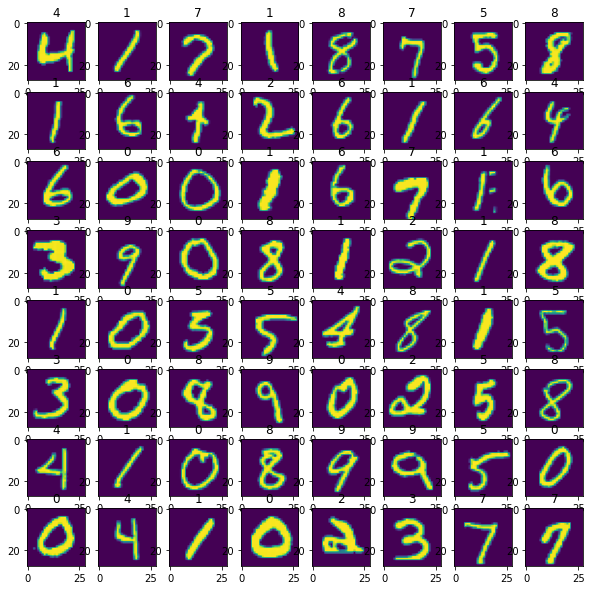

In [10]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*16+j]
        sample, label = train_dataset[sample_index]
        ax.imshow(sample.cpu().numpy().transpose(1, 2, 0))
        ax.set_title(label)

Training dataset consists of 60000 handwritten digits from _0_ to _9_  
Each training example is a 28x28 gray-scale image of a digit.  
For convenience each image will be reshaped from 28x28 matrix into 28^2 = 784-element row.  
Each pixel has a single pixel-value associated with it,  
indicating the lightness or darkness of that pixel, with higher numbers meaning lighter.

Plot the distribution of the target vectors

In [11]:
def dist_data(dataset, title):
    
    labels = list()
    
    for i in range(0, len(dataset)):
        labels.append(dataset[i][1])
    
    sns.histplot(labels)
    plt.title(title)
    plt.show()

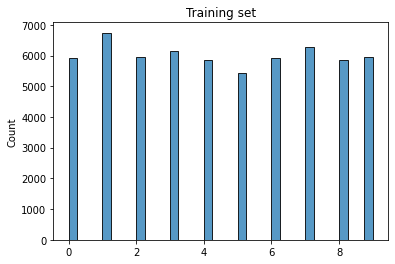

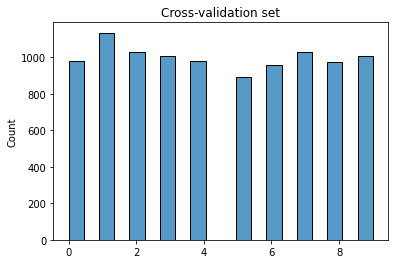

In [12]:
dist_data(train_dataset, 'Training set')
dist_data(valid_dataset, 'Cross-validation set')

# Task 5

In [13]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    
    model.train()
    loss_total = 0
    
    for data in data_loader:
        
        X, y = data
        X, y = X.view(-1, 784), y.to(device)
        X = X.to(device)
        
        model.zero_grad()
        output = model(X)
        
        loss = loss_function(output, y)
        loss_total += loss
        loss.backward()
        
        optimizer.step()
    
    loss_avg = loss_total / len(data_loader.dataset)
    
    return loss_avg

# Task 6

In [14]:
@torch.no_grad()
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    loss_total = 0
    accuracy_total = 0
    
    for data in data_loader:

        X, y = data
        X, y = X.view(-1, 784), y.to(device)
        X = X.to(device)
        
        output = model(X)
        
        loss = loss_function(output, y)
        loss_total += loss
        

        y_pred = output.argmax(dim = 1, keepdim=True).to(device)
        accuracy_total += y_pred.eq(y.view_as(y_pred)).sum().item()
        
    loss_avg = loss_total / len(data_loader.dataset)
    accuracy_avg = 100.0 * accuracy_total / len(data_loader.dataset)
    
    return {'loss' : loss_avg, 'accuracy' : accuracy_avg}

In [15]:
def plot_learning_curves(loss_list, accuracy_list, best_epoch):
    """
    Plot loss evolution on training and dev sets and
    accuracy evolution on dev set
    """
    
    # Plot learning loss curve
    plt.plot(loss_list['train'], label = 'Training set')
    plt.plot(loss_list['valid'], label = 'Dev set')
    plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best model')
    plt.title('Loss evolution')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Plot accuracy curve         
    plt.plot(accuracy_list, color = 'g', label = 'Dev set')
    plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best model')
    plt.title('Accuracy evolution on validation set')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [16]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                valid_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 1000,
                early_stopping_patience = 20, 
                best_model_root = './best_model.pth'):
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

    best_valid_loss = None
    best_epoch = None
    loss_list = {'train' : list(), 'valid' : list()}
    accuracy_list = list()
    
    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
        
        start = timer()
        
        train_loss = train_single_epoch(model, optimizer, loss_function, train_loader)
        
        # Evaluate perfomance on the training set
        loss_list['train'].append(train_loss)
        
        # Evaluate perfomance on the cross-validation set
        valid_metrics = validate_single_epoch(model, loss_function, valid_loader)
        loss_list['valid'].append(valid_metrics['loss'])
        accuracy_list.append(valid_metrics['accuracy'])
        
        print('time:', timer() - start)
        print(f'Validation metrics: \n{valid_metrics}')

        lr_scheduler.step(valid_metrics['loss'])
        
        if best_valid_loss is None or best_valid_loss > valid_metrics['loss']:
            print(f'-----Best model yet, saving-----')
            best_valid_loss = valid_metrics['loss']
            best_epoch = epoch
            torch.save(model, best_model_root)
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            plot_learning_curves(loss_list, accuracy_list, best_epoch)
            return

Epoch 0
time: 9.2618328
Validation metrics: 
{'loss': tensor(0.0004, device='cuda:0'), 'accuracy': 94.81}
-----Best model yet, saving-----
Epoch 1
time: 9.565792699999996
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.32}
-----Best model yet, saving-----
Epoch 2
time: 9.3888763
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.6}
-----Best model yet, saving-----
Epoch 3
time: 8.943925199999995
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.71}
-----Best model yet, saving-----
Epoch 4
time: 8.870754399999996
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.83}
Epoch 5
time: 8.6117232
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.72}
Epoch 6
time: 9.054406400000005
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.88}
-----Best model yet, saving-----
Epoch 7
time: 8.715660100000008
Validation metrics: 
{'loss': 

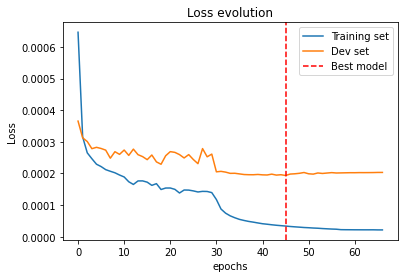

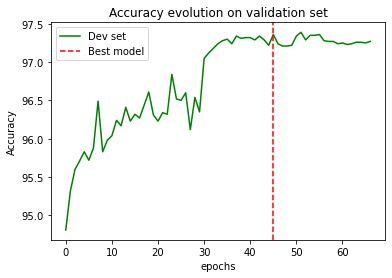

In [17]:
train_model(model, 
            train_dataset=train_dataset, 
            valid_dataset=valid_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01, max_epochs = 500, batch_size = 512)

In [18]:
best_model = torch.load('./best_model.pth')

# Task 7
### Custom network

In [19]:
class Net(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.fc1 = torch.nn.Linear(784, 256)
        self.fc2 = torch.nn.Linear(256, 256)
        self.fc3 = torch.nn.Linear(256, 10)
        
    def forward(self, X):
        
        X = self.fc1(X)
        X = F.tanh(X)
        X = self.fc2(X)
        X = F.tanh(X)
        X = self.fc3(X)
        
        output = F.log_softmax(X, dim = 1)
        
        return output

In [20]:
net = Net().to(device)

Epoch 0


c:\users\arsfi\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


time: 8.776288399999999
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.02}
-----Best model yet, saving-----
Epoch 1
time: 8.477145399999927
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.29}
-----Best model yet, saving-----
Epoch 2
time: 8.621021599999949
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.3}
-----Best model yet, saving-----
Epoch 3
time: 8.54345879999994
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.88}
-----Best model yet, saving-----
Epoch 4
time: 8.747871299999929
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.7}
Epoch 5
time: 9.271498899999983
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 95.94}
Epoch 6
time: 9.238938200000007
Validation metrics: 
{'loss': tensor(0.0003, device='cuda:0'), 'accuracy': 96.1}
Epoch 7
time: 8.643216099999904
Validation metrics: 
{'loss': tensor(0.0003, devic

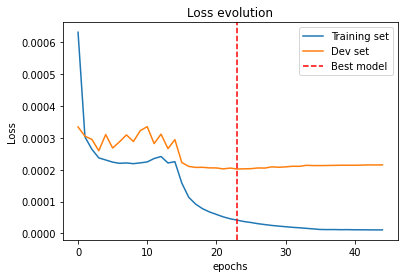

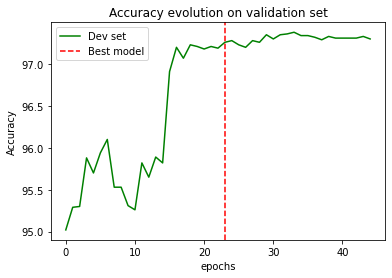

In [21]:
train_model(net, 
            train_dataset=train_dataset, 
            valid_dataset=valid_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.01, max_epochs = 500, batch_size = 512, best_model_root = './best_net.pth')

I've tried different models and the best perfomance was given by __model__ from previous tasks.  
Both models ended up with ~ 97% accuracy.